In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
!pip install pytorchfi

In [ ]:
import pytorchfi
import torch
import torchvision.models as models
import pytorchfi.core as pfi_core


### Helper functions

In [ ]:
def calculate_accuracy(model, data_loader):
    correct = 0
    total = 0
    model.to(device)
    model.eval()

    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    return correct / total


In [ ]:
from pytorchfi.weight_error_models import (
    random_weight_inj,
    random_weight_location,
    zero_func_rand_weight
)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pytorchfi
import pytorchfi.core as pfi_core

from pytorchfi.weight_error_models import (
    random_weight_inj,
    random_weight_location,
    zero_func_rand_weight
)

from pytorchfi.neuron_error_models import (
    random_inj_per_layer,
    random_inj_per_layer_batched,
    random_neuron_inj,
    random_neuron_inj_batched,
    random_neuron_single_bit_inj,
    random_neuron_single_bit_inj_batched,
    single_bit_flip_func,
)


In [ ]:
def get_predictions(model, test_loader, device):
    model.to(device)
    model.eval()
    predictions = []

    with torch.no_grad():
        for inputs, _ in test_loader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            predictions.extend(predicted.cpu().numpy())

    return predictions

# Припускаючи, що test_loader і device вже визначені
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


In [ ]:
import numpy as np
from scipy.stats import mode


def vote(predictions):
    # Перетворення списку прогнозів в numpy масив
    # Припускаємо, що predictions - це список списків прогнозів для кожного входу
    predictions_array = np.array(predictions)

    # Голосування за більшістю
    # mode() з scipy.stats знайде найбільш частий елемент у кожному стовпці
    voted_predictions = mode(predictions_array, axis=0)[0]

    # Вибірка першого рядка, оскільки mode повертає результат у форматі (результат, кількість)
    return voted_predictions[0]

# Приклад використання
# predictions = [[0, 1, 1, 0], [1, 1, 1, 0], [0, 1, 0, 0]]
# final_predictions = vote(predictions)


In [ ]:
import torch

def evaluate_ensemble_accuracy(ensemble_models, test_loader, device):
    for model in ensemble_models:
        model.eval()
        model.to(device)

    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            # Агрегація передбачень від усіх моделей
            ensemble_outputs = None
            for model in ensemble_models:
                outputs = model(inputs)
                if ensemble_outputs is None:
                    ensemble_outputs = outputs
                else:
                    ensemble_outputs += outputs

            # Вибір класу з найвищим загальним передбаченням
            _, predicted = torch.max(ensemble_outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    return accuracy



# resnet18

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

# Передобробка та завантаження даних CIFAR10
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),  # Випадкове горизонтальне перевертання для аугментації
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_set = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=128, shuffle=True, num_workers=2)

test_set = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=128, shuffle=False, num_workers=2)

# Визначення моделі ResNet18
resnet18_1 = models.resnet18(pretrained=True)
resnet18_2 = models.resnet18(pretrained=True)
resnet18_3 = models.resnet18(pretrained=True)
num_ftrs1 = resnet18_1.fc.in_features
num_ftrs2 = resnet18_2.fc.in_features
num_ftrs3 = resnet18_3.fc.in_features
resnet18_1.fc = nn.Linear(num_ftrs1, 10)  # CIFAR10 має 10 класів
resnet18_2.fc = nn.Linear(num_ftrs2, 10)  # CIFAR10 має 10 класів
resnet18_3.fc = nn.Linear(num_ftrs3, 10)  # CIFAR10 має 10 класів
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
resnet18_1.to(device)
resnet18_2.to(device)
resnet18_3.to(device)
# Визначення оптимізатора та функції втрат
optimizer1 = optim.Adam(resnet18_1.parameters(), lr=0.001)
optimizer2 = optim.Adam(resnet18_2.parameters(), lr=0.001)
optimizer3 = optim.Adam(resnet18_3.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

def train_model(model, criterion, optimizer, num_epochs=10):
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        correct_predictions = 0
        total_predictions = 0

        for i, (inputs, labels) in enumerate(train_loader, 0):
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total_predictions += labels.size(0)
            correct_predictions += (predicted == labels).sum().item()

        epoch_loss = running_loss / len(train_loader)
        epoch_acc = (correct_predictions / total_predictions) * 100

        print(f'Epoch {epoch + 1}/{num_epochs}, Accuracy: {epoch_acc:.2f}%')

    print('Finished Training')

# Тренування моделі
train_model(resnet18_1, criterion, optimizer1, num_epochs=10)
train_model(resnet18_2, criterion, optimizer2, num_epochs=10)
train_model(resnet18_3, criterion, optimizer3, num_epochs=10)


100%|██████████| 170498071/170498071 [00:13<00:00, 12491134.82it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 145MB/s]


Epoch 1/10, Accuracy: 69.82%
Epoch 2/10, Accuracy: 79.17%
Epoch 3/10, Accuracy: 82.14%
Epoch 4/10, Accuracy: 84.85%
Epoch 5/10, Accuracy: 86.55%
Epoch 6/10, Accuracy: 88.39%
Epoch 7/10, Accuracy: 89.58%
Epoch 8/10, Accuracy: 90.86%
Epoch 9/10, Accuracy: 91.04%
Epoch 10/10, Accuracy: 92.15%
Finished Training
Epoch 1/10, Accuracy: 69.73%
Epoch 2/10, Accuracy: 79.17%
Epoch 3/10, Accuracy: 82.84%
Epoch 4/10, Accuracy: 84.89%
Epoch 5/10, Accuracy: 86.91%
Epoch 6/10, Accuracy: 88.41%
Epoch 7/10, Accuracy: 89.59%
Epoch 8/10, Accuracy: 90.52%
Epoch 9/10, Accuracy: 91.91%
Epoch 10/10, Accuracy: 92.55%
Finished Training
Epoch 1/10, Accuracy: 69.82%
Epoch 2/10, Accuracy: 79.24%
Epoch 3/10, Accuracy: 82.78%
Epoch 4/10, Accuracy: 84.88%
Epoch 5/10, Accuracy: 86.55%
Epoch 6/10, Accuracy: 88.47%
Epoch 7/10, Accuracy: 89.62%
Epoch 8/10, Accuracy: 90.86%
Epoch 9/10, Accuracy: 91.66%
Epoch 10/10, Accuracy: 92.42%
Finished Training


In [ ]:
def evaluate_accuracy(model, test_loader, device):
    model.eval()  # Переведення моделі в режим оцінки
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    return accuracy

# Оцінка точності
accuracy = evaluate_accuracy(resnet18_1, test_loader, device)
print(f'Test Accuracy: {accuracy}%')


Test Accuracy: 82.88%


In [ ]:

accuracy = calculate_accuracy(resnet18_1, test_loader)
print(f'Test Accuracy: {accuracy}%')


Test Accuracy: 0.8306%


In [ ]:
ensemble_resnet18 = [resnet18_1,resnet18_2,resnet18_3]

accuracy_resnet18 = evaluate_ensemble_accuracy(ensemble_resnet18, test_loader, device)
print(f'Ensemble Accuracy: {accuracy_resnet18}%')

Ensemble Accuracy: 85.61%


In [ ]:
accuracy1 = evaluate_accuracy(resnet18_1, test_loader, device)
accuracy2 = evaluate_accuracy(resnet18_2, test_loader, device)
accuracy3 = evaluate_accuracy(resnet18_3, test_loader, device)

In [ ]:
print(f'Test Accuracy: {accuracy1}%')
print(f'Test Accuracy: {accuracy2}%')
print(f'Test Accuracy: {accuracy3}%')

Test Accuracy: 83.57%
Test Accuracy: 83.31%
Test Accuracy: 83.14%


In [ ]:
accuracy1 = evaluate_accuracy(mobilenet_1, test_loader, device)
accuracy2 = evaluate_accuracy(mobilenet_2, test_loader, device)
accuracy3 = evaluate_accuracy(mobilenet_3, test_loader, device)

In [ ]:
print(f'Test Accuracy: {accuracy1}%')
print(f'Test Accuracy: {accuracy2}%')
print(f'Test Accuracy: {accuracy3}%')

In [ ]:
accuracy1 = evaluate_accuracy(resnet50_1, test_loader, device)
accuracy2 = evaluate_accuracy(resnet50_2, test_loader, device)
accuracy3 = evaluate_accuracy(resnet50_3, test_loader, device)

In [ ]:
print(f'Test Accuracy: {accuracy1}%')
print(f'Test Accuracy: {accuracy2}%')
print(f'Test Accuracy: {accuracy3}%')

Test Accuracy: 84.57%
Test Accuracy: 84.16%
Test Accuracy: 80.58%


In [ ]:
predictions1 = get_predictions(resnet18_1,test_loader,device)
predictions2 = get_predictions(resnet18_1,test_loader,device)
predictions3 = get_predictions(resnet18_1,test_loader,device)

In [ ]:
predictions_arr = [predictions1,predictions2,predictions3]

In [ ]:
predictions = get_predictions(resnet18,test_loader,device)

In [ ]:
bote = vote(predictions_arr)
print(bote)

3


In [ ]:
print(predictions)

[3, 1, 8, 0, 6, 6, 9, 6, 3, 1, 0, 9, 5, 7, 9, 8, 5, 7, 8, 6, 9, 0, 4, 9, 4, 2, 7, 0, 9, 6, 6, 5, 4, 2, 9, 3, 7, 9, 9, 5, 4, 6, 7, 6, 0, 9, 3, 8, 7, 6, 9, 8, 0, 5, 8, 8, 7, 3, 3, 2, 7, 5, 6, 3, 6, 2, 1, 2, 3, 7, 2, 6, 0, 8, 8, 2, 0, 3, 3, 8, 8, 1, 1, 7, 2, 7, 4, 7, 8, 9, 0, 6, 8, 6, 4, 6, 2, 0, 0, 7, 7, 5, 6, 3, 1, 1, 5, 6, 8, 7, 4, 0, 6, 2, 1, 3, 0, 4, 6, 7, 8, 3, 1, 2, 8, 0, 9, 3, 3, 0, 2, 1, 8, 9, 1, 2, 9, 7, 6, 8, 6, 5, 6, 5, 8, 7, 6, 5, 5, 2, 8, 9, 6, 0, 0, 5, 2, 9, 5, 4, 2, 1, 6, 6, 0, 2, 8, 4, 5, 0, 9, 7, 9, 8, 9, 9, 3, 7, 5, 0, 0, 5, 2, 3, 0, 8, 6, 2, 3, 0, 6, 8, 0, 9, 7, 2, 8, 8, 7, 8, 5, 1, 8, 7, 1, 3, 0, 5, 7, 9, 5, 4, 5, 9, 8, 0, 7, 9, 8, 2, 7, 6, 9, 7, 3, 9, 4, 4, 3, 2, 5, 1, 7, 8, 8, 0, 4, 7, 5, 5, 1, 1, 8, 9, 0, 6, 1, 8, 2, 2, 5, 3, 9, 9, 2, 3, 3, 0, 0, 9, 8, 1, 5, 7, 0, 8, 5, 4, 7, 0, 2, 3, 6, 3, 8, 5, 0, 2, 4, 5, 9, 0, 6, 1, 0, 9, 1, 0, 7, 9, 1, 2, 6, 9, 3, 4, 6, 0, 0, 6, 6, 6, 5, 2, 6, 1, 8, 2, 1, 4, 8, 6, 0, 2, 5, 0, 4, 7, 5, 5, 3, 5, 2, 5, 3, 5, 7, 5, 4, 6, 1, 9, 6, 

In [ ]:
path_on_drive = '/content/drive/My Drive/diploma/resnet18_1.pth'  # Замініть шлях на вашу папку на Google Drive
torch.save(resnet18_1.state_dict(), path_on_drive)
path_on_drive = '/content/drive/My Drive/diploma/resnet18_2.pth'  # Замініть шлях на вашу папку на Google Drive
torch.save(resnet18_2.state_dict(), path_on_drive)
path_on_drive = '/content/drive/My Drive/diploma/resnet18_3.pth'  # Замініть шлях на вашу папку на Google Drive
torch.save(resnet18_3.state_dict(), path_on_drive)

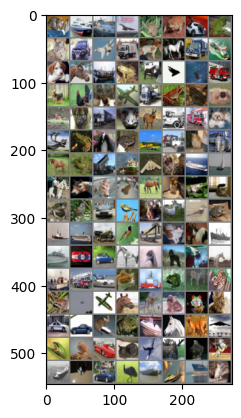

Labels:  3


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torchvision

# Функція для перетворення тензора у зображення
def imshow(img):
    img = img / 2 + 0.5     # денормалізація
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Отримання декількох зображень
dataiter = iter(test_loader)
images, labels = next(dataiter)

# Показ зображень
imshow(torchvision.utils.make_grid(images))

# Вивід міток
print('Labels: ', ' '.join(f'{labels[j].item()}' for j in range(batch_size)))


In [ ]:
fi_resnet18_1 = pytorchfi.core.fault_injection(
    model=resnet18_1,
    batch_size=1,  # розмір пакету
    layer_types=[torch.nn.Conv2d],  # Типи шарів, до яких застосовуються помилки
)
fi_resnet18_2 = pytorchfi.core.fault_injection(
    model=resnet18_2,
    batch_size=1,  # розмір пакету
    layer_types=[torch.nn.Conv2d],  # Типи шарів, до яких застосовуються помилки
)
fi_resnet18_3 = pytorchfi.core.fault_injection(
    model=resnet18_3,
    batch_size=1,  # розмір пакету
    layer_types=[torch.nn.Conv2d],  # Типи шарів, до яких застосовуються помилки
)
corrupt_resnet18_1 =  random_weight_inj(
            fi_resnet18_1, corrupt_layer=3, min_val=20, max_val=30
        )

corrupt_resnet18_2 =  random_weight_inj(
            fi_resnet18_2, corrupt_layer=3, min_val=20, max_val=30
        )

corrupt_resnet18_3 =  random_weight_inj(
            fi_resnet18_3, corrupt_layer=3, min_val=20, max_val=30
        )

predictions_resnet18_1 = get_predictions(corrupt_resnet18_1, test_loader, device)
predictions_resnet18_2 = get_predictions(corrupt_resnet18_2, test_loader, device)
predictions_resnet18_3 = get_predictions(corrupt_resnet18_3, test_loader, device)

predictions2 = [predictions_resnet18_1, predictions_resnet18_2, predictions_resnet18_3]
final_predictions2 = vote(predictions2)
print(final_predictions2)

3


In [ ]:
fi_resnet18_1 = pytorchfi.core.fault_injection(
    model=resnet18_1,
    batch_size=1,  # розмір пакету
    layer_types=[torch.nn.Conv2d],  # Типи шарів, до яких застосовуються помилки
)
fi_resnet18_2 = pytorchfi.core.fault_injection(
    model=resnet18_2,
    batch_size=1,  # розмір пакету
    layer_types=[torch.nn.Conv2d],  # Типи шарів, до яких застосовуються помилки
)
fi_resnet18_3 = pytorchfi.core.fault_injection(
    model=resnet18_3,
    batch_size=1,  # розмір пакету
    layer_types=[torch.nn.Conv2d],  # Типи шарів, до яких застосовуються помилки
)
corrupt_resnet18_1 =  random_weight_inj(
            fi_resnet18_1,  min_val=10, max_val=30
        )

corrupt_resnet18_2 =  random_weight_inj(
            fi_resnet18_2,  min_val=10, max_val=30
        )

corrupt_resnet18_3 =  random_weight_inj(
            fi_resnet18_3,  min_val=10, max_val=30
        )

predictions_resnet18_1 = get_predictions(corrupt_resnet18_1, test_loader, device)
predictions_resnet18_2 = get_predictions(corrupt_resnet18_2, test_loader, device)
predictions_resnet18_3 = get_predictions(corrupt_resnet18_3, test_loader, device)

predictions2 = [predictions_resnet18_1, predictions_resnet18_2, predictions_resnet18_3]
final_predictions2 = vote(predictions2)
print(final_predictions2)

3


In [ ]:
ensemble_resnet18_corrupt = [corrupt_resnet18_1, corrupt_resnet18_2,corrupt_resnet18_3]

In [ ]:
ensemble_resnet18 = [resnet18_1, resnet18_2,resnet18_3]

In [ ]:
accuracy = evaluate_ensemble_accuracy(ensemble_resnet18, test_loader, device)
print(f'Ensemble Accuracy: {accuracy}%')

accuracy_inject = evaluate_ensemble_accuracy(ensemble_resnet18_corrupt, test_loader, device)
print(f'Ensemble Accuracy: {accuracy_inject}%')

R = 1 - (accuracy-accuracy_inject)/accuracy
print(R)

Ensemble Accuracy: 85.94%
Ensemble Accuracy: 75.65%
0.880265301373051


In [ ]:
fi_resnet18_1 = pytorchfi.core.fault_injection(
    model=resnet18_1,
    batch_size=1,  # розмір пакету
    layer_types=[torch.nn.Conv2d],  # Типи шарів, до яких застосовуються помилки
)
fi_resnet18_2 = pytorchfi.core.fault_injection(
    model=resnet18_2,
    batch_size=1,  # розмір пакету
    layer_types=[torch.nn.Conv2d],  # Типи шарів, до яких застосовуються помилки
)
fi_resnet18_3 = pytorchfi.core.fault_injection(
    model=resnet18_3,
    batch_size=1,  # розмір пакету
    layer_types=[torch.nn.Conv2d],  # Типи шарів, до яких застосовуються помилки
)
corrupt_resnet18_1 =  zero_func_rand_weight(
            fi_resnet18_1
        )

corrupt_resnet18_2 =  zero_func_rand_weight(
            fi_resnet18_2
        )

corrupt_resnet18_3 =  zero_func_rand_weight(
            fi_resnet18_3
        )

predictions_resnet18_1 = get_predictions(corrupt_resnet18_1, test_loader, device)
predictions_resnet18_2 = get_predictions(corrupt_resnet18_2, test_loader, device)
predictions_resnet18_3 = get_predictions(corrupt_resnet18_3, test_loader, device)

predictions2 = [predictions_resnet18_1, predictions_resnet18_2, predictions_resnet18_3]
final_predictions2 = vote(predictions2)
print(final_predictions2)

3


In [ ]:
ensemble_resnet18_corrupt = [corrupt_resnet18_1,corrupt_resnet18_2,corrupt_resnet18_3]

In [ ]:
#ZEROS
accuracy = evaluate_ensemble_accuracy(ensemble_resnet18, test_loader, device)
print(f'Ensemble Accuracy: {accuracy}%')

accuracy_inject = evaluate_ensemble_accuracy(ensemble_resnet18_corrupt, test_loader, device)
print(f'Ensemble Accuracy: {accuracy_inject}%')

R = 1 - (accuracy-accuracy_inject)/accuracy
print(R)

Ensemble Accuracy: 85.65%
Ensemble Accuracy: 85.76%
1.0012842965557502


# ResNet50

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

# Передобробка та завантаження даних CIFAR10
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),  # Випадкове горизонтальне перевертання для аугментації
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_set = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=128, shuffle=True, num_workers=2)

test_set = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=128, shuffle=False, num_workers=2)

# Визначення моделі ResNet50
resnet50_1 = models.resnet50(pretrained=True)
num_ftrs = resnet50_1.fc.in_features
resnet50_1.fc = nn.Linear(num_ftrs, 10)  # CIFAR10 має 10 класів

resnet50_2 = models.resnet50(pretrained=True)
num_ftrs = resnet50_2.fc.in_features
resnet50_2.fc = nn.Linear(num_ftrs, 10)  # CIFAR10 має 10 класів

resnet50_3 = models.resnet50(pretrained=True)
num_ftrs = resnet50_3.fc.in_features
resnet50_3.fc = nn.Linear(num_ftrs, 10)  # CIFAR10 має 10 класів

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
resnet50_1.to(device)
resnet50_2.to(device)
resnet50_3.to(device)
# Визначення оптимізатора та функції втрат

optimizer11 = optim.Adam(resnet50_1.parameters(), lr=0.001)
optimizer12 = optim.Adam(resnet50_2.parameters(), lr=0.001)
optimizer13 = optim.Adam(resnet50_3.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

# Функція для тренування моделі (аналогічна функції для ResNet18)
def train_model(model, train_loader, criterion, optimizer, device, num_epochs=10):
    model.to(device)
    model.train()
    for epoch in range(num_epochs):
        correct_predictions = 0
        total_predictions = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            _, predicted = torch.max(outputs.data, 1)
            total_predictions += labels.size(0)
            correct_predictions += (predicted == labels).sum().item()

        accuracy = 100 * correct_predictions / total_predictions
        print(f'Epoch {epoch + 1}/{num_epochs}, Accuracy: {accuracy:.2f}%')

    print('Finished Training')


# Тренування моделі
train_model(resnet50_1,train_loader,  criterion, optimizer11, device)
train_model(resnet50_2, train_loader, criterion, optimizer12, device)
train_model(resnet50_3, train_loader, criterion, optimizer13, device)

Files already downloaded and verified
Files already downloaded and verified


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/10, Accuracy: 71.09%
Epoch 2/10, Accuracy: 78.28%
Epoch 3/10, Accuracy: 83.10%
Epoch 4/10, Accuracy: 85.80%
Epoch 5/10, Accuracy: 87.40%
Epoch 6/10, Accuracy: 82.30%
Epoch 7/10, Accuracy: 86.58%
Epoch 8/10, Accuracy: 90.16%
Epoch 9/10, Accuracy: 91.70%
Epoch 10/10, Accuracy: 92.56%
Finished Training
Epoch 1/10, Accuracy: 69.87%
Epoch 2/10, Accuracy: 79.46%
Epoch 3/10, Accuracy: 82.94%
Epoch 4/10, Accuracy: 85.84%
Epoch 5/10, Accuracy: 87.25%
Epoch 6/10, Accuracy: 83.84%
Epoch 7/10, Accuracy: 88.80%
Epoch 8/10, Accuracy: 88.27%
Epoch 9/10, Accuracy: 91.37%
Epoch 10/10, Accuracy: 92.30%
Finished Training
Epoch 1/10, Accuracy: 68.18%
Epoch 2/10, Accuracy: 80.13%
Epoch 3/10, Accuracy: 83.35%
Epoch 4/10, Accuracy: 84.05%
Epoch 5/10, Accuracy: 86.25%
Epoch 6/10, Accuracy: 88.57%
Epoch 7/10, Accuracy: 89.71%
Epoch 8/10, Accuracy: 90.69%
Epoch 9/10, Accuracy: 91.79%
Epoch 10/10, Accuracy: 91.88%
Finished Training


In [ ]:
fi_resnet50_1 = pytorchfi.core.fault_injection(
    model=resnet50_1,
    batch_size=1,  #  розмір пакету
    layer_types=[torch.nn.Conv2d],  # Типи шарів, до яких застосовуються помилки
)
fi_resnet50_2 = pytorchfi.core.fault_injection(
    model=resnet50_2,
    batch_size=1,  #  розмір пакету
    layer_types=[torch.nn.Conv2d],  # Типи шарів, до яких застосовуються помилки
)
fi_resnet50_3 = pytorchfi.core.fault_injection(
    model=resnet50_3,
    batch_size=1,  #  розмір пакету
    layer_types=[torch.nn.Conv2d],  # Типи шарів, до яких застосовуються помилки
)
corrupt_resnet50_1 =  random_weight_inj(
            fi_resnet50_1, corrupt_layer=3, min_val=20, max_val=30
        )

corrupt_resnet50_2 =  random_weight_inj(
            fi_resnet50_2, corrupt_layer=3, min_val=20, max_val=30
        )

corrupt_resnet50_3 =  random_weight_inj(
            fi_resnet50_3, corrupt_layer=3, min_val=20, max_val=30
        )

predictions_resnet50_1 = get_predictions(corrupt_resnet50_1, test_loader, device)
predictions_resnet50_2 = get_predictions(corrupt_resnet50_2, test_loader, device)
predictions_resnet50_3 = get_predictions(corrupt_resnet50_3, test_loader, device)

predictions2 = [predictions_resnet50_1, predictions_resnet50_2, predictions_resnet50_3]
final_predictions2 = vote(predictions2)
print(final_predictions2)

3


In [ ]:
fi_resnet50_1 = pytorchfi.core.fault_injection(
    model=resnet50_1,
    batch_size=1,  #  розмір пакету
    layer_types=[torch.nn.Conv2d],  # Типи шарів, до яких застосовуються помилки
)
fi_resnet50_2 = pytorchfi.core.fault_injection(
    model=resnet50_2,
    batch_size=1,  #  розмір пакету
    layer_types=[torch.nn.Conv2d],  # Типи шарів, до яких застосовуються помилки
)
fi_resnet50_3 = pytorchfi.core.fault_injection(
    model=resnet50_3,
    batch_size=1,  #  розмір пакету
    layer_types=[torch.nn.Conv2d],  # Типи шарів, до яких застосовуються помилки
)
corrupt_resnet50_1 =  random_weight_inj(
            fi_resnet50_1, min_val=10, max_val=30
        )

corrupt_resnet50_2 =  random_weight_inj(
            fi_resnet50_2, min_val=10, max_val=30
        )

corrupt_resnet50_3 =  random_weight_inj(
            fi_resnet50_3, min_val=10, max_val=30
        )

predictions_resnet50_1 = get_predictions(corrupt_resnet50_1, test_loader, device)
predictions_resnet50_2 = get_predictions(corrupt_resnet50_2, test_loader, device)
predictions_resnet50_3 = get_predictions(corrupt_resnet50_3, test_loader, device)

predictions2 = [predictions_resnet50_1, predictions_resnet50_2, predictions_resnet50_3]
final_predictions2 = vote(predictions2)
print(final_predictions2)

3


In [ ]:
ensemble_resnet50 = [resnet50_1,resnet50_2,resnet50_3]
ensemble_resnet50_corrupt = [corrupt_resnet50_1,corrupt_resnet50_2,corrupt_resnet50_3]
accuracy = evaluate_ensemble_accuracy(ensemble_resnet50, test_loader, device)
print(f'Ensemble Accuracy: {accuracy}%')

accuracy_inject = evaluate_ensemble_accuracy(ensemble_resnet50_corrupt, test_loader, device)
print(f'Ensemble Accuracy: {accuracy_inject}%')

R = 1 - (accuracy-accuracy_inject)/accuracy
print(R)


NameError: ignored

In [ ]:
fi_resnet50_1 = pytorchfi.core.fault_injection(
    model=resnet50_1,
    batch_size=1,  #  розмір пакету
    layer_types=[torch.nn.Conv2d],  # Типи шарів, до яких застосовуються помилки
)
fi_resnet50_2 = pytorchfi.core.fault_injection(
    model=resnet50_2,
    batch_size=1,  #  розмір пакету
    layer_types=[torch.nn.Conv2d],  # Типи шарів, до яких застосовуються помилки
)
fi_resnet50_3 = pytorchfi.core.fault_injection(
    model=resnet50_3,
    batch_size=1,  #  розмір пакету
    layer_types=[torch.nn.Conv2d],  # Типи шарів, до яких застосовуються помилки
)
corrupt_resnet50_1 =  random_weight_inj(
            fi_resnet50_1, min_val=10, max_val=30
        )

corrupt_resnet50_2 =  random_weight_inj(
            fi_resnet50_2, min_val=10, max_val=30
        )

corrupt_resnet50_3 =  random_weight_inj(
            fi_resnet50_3, min_val=10, max_val=30
        )

predictions_resnet50_1 = get_predictions(corrupt_resnet50_1, test_loader, device)
predictions_resnet50_2 = get_predictions(corrupt_resnet50_2, test_loader, device)
predictions_resnet50_3 = get_predictions(corrupt_resnet50_3, test_loader, device)

predictions2 = [predictions_resnet50_1, predictions_resnet50_2, predictions_resnet50_3]
final_predictions2 = vote(predictions2)
print(final_predictions2)

In [ ]:
ensemble_resnet50 = [resnet50_1,resnet50_2,resnet50_3]
ensemble_resnet50_corrupt = [corrupt_resnet50_1,corrupt_resnet50_2,corrupt_resnet50_3]
accuracy = evaluate_ensemble_accuracy(ensemble_resnet50, test_loader, device)
print(f'Ensemble Accuracy: {accuracy}%')

accuracy_inject = evaluate_ensemble_accuracy(ensemble_resnet50_corrupt, test_loader, device)
print(f'Ensemble Accuracy: {accuracy_inject}%')

R = 1 - (accuracy-accuracy_inject)/accuracy
print(R)


Ensemble Accuracy: 87.26%
Ensemble Accuracy: 86.81%
0.9948429979371991


In [ ]:
fi_resnet50_1 = pytorchfi.core.fault_injection(
    model=resnet50_1,
    batch_size=1,  #  розмір пакету
    layer_types=[torch.nn.Conv2d],  # Типи шарів, до яких застосовуються помилки
)
fi_resnet50_2 = pytorchfi.core.fault_injection(
    model=resnet50_2,
    batch_size=1,  #  розмір пакету
    layer_types=[torch.nn.Conv2d],  # Типи шарів, до яких застосовуються помилки
)
fi_resnet50_3 = pytorchfi.core.fault_injection(
    model=resnet50_3,
    batch_size=1,  #  розмір пакету
    layer_types=[torch.nn.Conv2d],  # Типи шарів, до яких застосовуються помилки
)
corrupt_resnet50_1 =  zero_func_rand_weight(
            fi_resnet50_1
        )

corrupt_resnet50_2 =  zero_func_rand_weight(
            fi_resnet50_2
        )

corrupt_resnet50_3 =  zero_func_rand_weight(
            fi_resnet50_3
        )

predictions_resnet50_1 = get_predictions(corrupt_resnet50_1, test_loader, device)
predictions_resnet50_2 = get_predictions(corrupt_resnet50_2, test_loader, device)
predictions_resnet50_3 = get_predictions(corrupt_resnet50_3, test_loader, device)

predictions2 = [predictions_resnet50_1, predictions_resnet50_2, predictions_resnet50_3]
final_predictions2 = vote(predictions2)
print(final_predictions2)

3


In [ ]:
#Zeros
ensemble_resnet50 = [resnet50_1,resnet50_2,resnet50_3]
ensemble_resnet50_corrupt = [corrupt_resnet50_1,corrupt_resnet50_2,corrupt_resnet50_3]
accuracy = evaluate_ensemble_accuracy(ensemble_resnet50, test_loader, device)
print(f'Ensemble Accuracy: {accuracy}%')

accuracy_inject = evaluate_ensemble_accuracy(ensemble_resnet50_corrupt, test_loader, device)
print(f'Ensemble Accuracy: {accuracy_inject}%')

R = 1 - (accuracy-accuracy_inject)/accuracy
print(R)


Ensemble Accuracy: 79.19%
Ensemble Accuracy: 79.44%
1.0031569642631646


# MobileNet

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim


# Визначення моделі MobileNet
mobilenet_1 = models.mobilenet_v2(pretrained=True)
num_ftrs = mobilenet_1.classifier[1].in_features
mobilenet_1.classifier = nn.Sequential(
    nn.Linear(num_ftrs, 10)  # CIFAR10 має 10 класів
)
mobilenet_2 = models.mobilenet_v2(pretrained=True)
num_ftrs = mobilenet_2.classifier[1].in_features
mobilenet_2.classifier = nn.Sequential(
    nn.Linear(num_ftrs, 10)  # CIFAR10 має 10 класів
)
mobilenet_3 = models.mobilenet_v2(pretrained=True)
num_ftrs = mobilenet_3.classifier[1].in_features
mobilenet_3.classifier = nn.Sequential(
    nn.Linear(num_ftrs, 10)  # CIFAR10 має 10 класів
)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
mobilenet_1.to(device)
mobilenet_2.to(device)
mobilenet_3.to(device)
# Визначення оптимізатора та функції втрат
optimizer21 = optim.Adam(mobilenet_1.parameters(), lr=0.001)
optimizer22 = optim.Adam(mobilenet_2.parameters(), lr=0.001)
optimizer23 = optim.Adam(mobilenet_3.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()
def train_model(model, train_loader, criterion, optimizer, device, num_epochs=10):
    model.to(device)
    model.train()

    for epoch in range(num_epochs):
        correct_predictions = 0
        total_predictions = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            _, predicted = torch.max(outputs.data, 1)
            total_predictions += labels.size(0)
            correct_predictions += (predicted == labels).sum().item()

        accuracy = 100 * correct_predictions / total_predictions
        print(f'Epoch {epoch + 1}/{num_epochs}, Accuracy: {accuracy:.2f}%')

    print('Finished Training')


# Тренування моделі
train_model(mobilenet_1,train_loader,  criterion, optimizer21, device, num_epochs=10)
train_model(mobilenet_2, train_loader, criterion, optimizer22, device, num_epochs=10)
train_model(mobilenet_3,train_loader,  criterion, optimizer23, device, num_epochs=10)

Epoch 1/10, Accuracy: 69.22%
Epoch 2/10, Accuracy: 79.16%
Epoch 3/10, Accuracy: 82.06%
Epoch 4/10, Accuracy: 83.77%
Epoch 5/10, Accuracy: 85.19%
Epoch 6/10, Accuracy: 82.20%
Epoch 7/10, Accuracy: 77.77%
Epoch 8/10, Accuracy: 82.61%
Epoch 9/10, Accuracy: 85.90%
Epoch 10/10, Accuracy: 85.54%
Finished Training
Epoch 1/10, Accuracy: 69.29%
Epoch 2/10, Accuracy: 78.81%
Epoch 3/10, Accuracy: 81.92%
Epoch 4/10, Accuracy: 83.67%
Epoch 5/10, Accuracy: 84.68%
Epoch 6/10, Accuracy: 85.60%
Epoch 7/10, Accuracy: 86.63%
Epoch 8/10, Accuracy: 87.71%
Epoch 9/10, Accuracy: 88.09%
Epoch 10/10, Accuracy: 89.05%
Finished Training
Epoch 1/10, Accuracy: 69.09%
Epoch 2/10, Accuracy: 79.08%
Epoch 3/10, Accuracy: 81.37%
Epoch 4/10, Accuracy: 83.48%
Epoch 5/10, Accuracy: 84.76%
Epoch 6/10, Accuracy: 85.25%
Epoch 7/10, Accuracy: 86.17%
Epoch 8/10, Accuracy: 87.22%
Epoch 9/10, Accuracy: 87.32%
Epoch 10/10, Accuracy: 88.12%
Finished Training


In [ ]:
fi_mobilenet_1 = pytorchfi.core.fault_injection(
    model=mobilenet_1,
    batch_size=1,  # Ваш розмір пакету
    layer_types=[torch.nn.Conv2d],  # Типи шарів, до яких застосовуються помилки
)
fi_mobilenet_2 = pytorchfi.core.fault_injection(
    model=mobilenet_2,
    batch_size=1,  # Ваш розмір пакету
    layer_types=[torch.nn.Conv2d],  # Типи шарів, до яких застосовуються помилки
)
fi_mobilenet_3 = pytorchfi.core.fault_injection(
    model=mobilenet_3,
    batch_size=1,  # Ваш розмір пакету
    layer_types=[torch.nn.Conv2d],  # Типи шарів, до яких застосовуються помилки
)
corrupt_mobilenet_1 =  random_weight_inj(
            fi_mobilenet_1, corrupt_layer=3, min_val=20, max_val=30
        )

corrupt_mobilenet_2 =  random_weight_inj(
            fi_mobilenet_2, corrupt_layer=3, min_val=20, max_val=30
        )

corrupt_mobilenet_3 =  random_weight_inj(
            fi_mobilenet_3, corrupt_layer=3, min_val=20, max_val=30
        )
# Тепер mobilenet_2 готова до використання з новими вагами і налаштованим класифікатором
predictions_mobilenet_1 = get_predictions(corrupt_mobilenet_1, test_loader, device)
predictions_mobilenet_2 = get_predictions(corrupt_mobilenet_2, test_loader, device)
predictions_mobilenet_3 = get_predictions(corrupt_mobilenet_3, test_loader, device)

predictions3 = [predictions_mobilenet_1, predictions_mobilenet_2, predictions_mobilenet_3]
final_predictions3 = vote(predictions3)
print(final_predictions3)

3


In [ ]:
fi_mobilenet_1 = pytorchfi.core.fault_injection(
    model=mobilenet_1,
    batch_size=1,  # Ваш розмір пакету
    layer_types=[torch.nn.Conv2d],  # Типи шарів, до яких застосовуються помилки
)
fi_mobilenet_2 = pytorchfi.core.fault_injection(
    model=mobilenet_2,
    batch_size=1,  # Ваш розмір пакету
    layer_types=[torch.nn.Conv2d],  # Типи шарів, до яких застосовуються помилки
)
fi_mobilenet_3 = pytorchfi.core.fault_injection(
    model=mobilenet_3,
    batch_size=1,  # Ваш розмір пакету
    layer_types=[torch.nn.Conv2d],  # Типи шарів, до яких застосовуються помилки
)
corrupt_mobilenet_1 =  random_weight_inj(
            fi_mobilenet_1, min_val=10, max_val=30
        )

corrupt_mobilenet_2 =  random_weight_inj(
            fi_mobilenet_2, min_val=10, max_val=30
        )

corrupt_mobilenet_3 =  random_weight_inj(
            fi_mobilenet_3, min_val=10, max_val=30
        )
# Тепер mobilenet_2 готова до використання з новими вагами і налаштованим класифікатором
predictions_mobilenet_1 = get_predictions(corrupt_mobilenet_1, test_loader, device)
predictions_mobilenet_2 = get_predictions(corrupt_mobilenet_2, test_loader, device)
predictions_mobilenet_3 = get_predictions(corrupt_mobilenet_3, test_loader, device)

predictions3 = [predictions_mobilenet_1, predictions_mobilenet_2, predictions_mobilenet_3]
final_predictions3 = vote(predictions3)
print(final_predictions3)

0


In [ ]:
fi_mobilenet_1 = pytorchfi.core.fault_injection(
    model=mobilenet_1,
    batch_size=1,  # Ваш розмір пакету
    layer_types=[torch.nn.Conv2d],  # Типи шарів, до яких застосовуються помилки
)
fi_mobilenet_2 = pytorchfi.core.fault_injection(
    model=mobilenet_2,
    batch_size=1,  # Ваш розмір пакету
    layer_types=[torch.nn.Conv2d],  # Типи шарів, до яких застосовуються помилки
)
fi_mobilenet_3 = pytorchfi.core.fault_injection(
    model=mobilenet_3,
    batch_size=1,  # Ваш розмір пакету
    layer_types=[torch.nn.Conv2d],  # Типи шарів, до яких застосовуються помилки
)
corrupt_mobilenet_1 =  zero_func_rand_weight(
            fi_mobilenet_1
        )

corrupt_mobilenet_2 =  zero_func_rand_weight(
            fi_mobilenet_2
        )

corrupt_mobilenet_3 =  zero_func_rand_weight(
            fi_mobilenet_3
        )
# Тепер mobilenet_2 готова до використання з новими вагами і налаштованим класифікатором
predictions_mobilenet_1 = get_predictions(corrupt_mobilenet_1, test_loader, device)
predictions_mobilenet_2 = get_predictions(corrupt_mobilenet_2, test_loader, device)
predictions_mobilenet_3 = get_predictions(corrupt_mobilenet_3, test_loader, device)

predictions3 = [predictions_mobilenet_1, predictions_mobilenet_2, predictions_mobilenet_3]
final_predictions3 = vote(predictions3)
print(final_predictions3)

3


In [ ]:
batch_size = 1
workers = 2
channels = 3
img_size = 32
use_gpu = False

fi_mobilenet_12 = pytorchfi.core.fault_injection(
    model=mobilenet_1,
    batch_size=1,  # Ваш розмір пакету,
    input_shape=[channels, img_size, img_size],
    layer_types=[torch.nn.Conv2d],  # Типи шарів, до яких застосовуються помилки
)

corrupt_mobilenet_3 =  random_neuron_inj(
            fi_mobilenet_3, min_val=0, max_val=1)


In [ ]:
predictions_mobilenet_3 = get_predictions(corrupt_mobilenet_3, test_loader, device)

IndexError: ignored

In [ ]:
#zeros
ensemble_mobilenet = [mobilenet_1,mobilenet_2,mobilenet_3]
ensemble_mobilenet_corrupt = [corrupt_mobilenet_1,corrupt_mobilenet_2,corrupt_mobilenet_3]
accuracy = evaluate_ensemble_accuracy(ensemble_mobilenet, test_loader, device)
print(f'Ensemble Accuracy: {accuracy}%')

accuracy_inject = evaluate_ensemble_accuracy(ensemble_mobilenet_corrupt, test_loader, device)
print(f'Ensemble Accuracy: {accuracy_inject}%')

R = 1 - (accuracy-accuracy_inject)/accuracy
print(R)



Ensemble Accuracy: 82.41%
Ensemble Accuracy: 82.3%
0.9986652105327023


# Resnet50 + Resnet18 + MobileNet

In [ ]:
ensemble_diff = [resnet50_1,resnet18_1,mobilenet_1]
ensemble_diff_corrupt = [corrupt_resnet50_1,corrupt_resnet18_1,corrupt_mobilenet_1]
accuracy = evaluate_ensemble_accuracy(ensemble_diff, test_loader, device)
print(f'Ensemble Accuracy: {accuracy}%')

accuracy_inject = evaluate_ensemble_accuracy(ensemble_diff_corrupt, test_loader, device)
print(f'Ensemble Accuracy: {accuracy_inject}%')

R = 1 - (accuracy-accuracy_inject)/accuracy
print(R)


Ensemble Accuracy: 87.78%
Ensemble Accuracy: 83.51%
0.9513556618819777


In [ ]:
#zeros

ensemble_diff = [resnet50_1,resnet18_1,mobilenet_1]
ensemble_diff_corrupt = [corrupt_resnet50_1,corrupt_resnet18_1,corrupt_mobilenet_1]
accuracy = evaluate_ensemble_accuracy(ensemble_diff, test_loader, device)
print(f'Ensemble Accuracy: {accuracy}%')

accuracy_inject = evaluate_ensemble_accuracy(ensemble_diff_corrupt, test_loader, device)
print(f'Ensemble Accuracy: {accuracy_inject}%')

R = 1 - (accuracy-accuracy_inject)/accuracy
print(R)


Ensemble Accuracy: 85.99%
Ensemble Accuracy: 85.94%
0.9994185370391906


In [ ]:
ensemble_diff = [resnet50_1,resnet18_1,mobilenet_1]
ensemble_diff_corrupt = [corrupt_resnet50_1,corrupt_resnet18_1,corrupt_mobilenet_1]
accuracy = evaluate_ensemble_accuracy(ensemble_diff, test_loader, device)
print(f'Ensemble Accuracy: {accuracy}%')

accuracy_inject = evaluate_ensemble_accuracy(ensemble_diff_corrupt, test_loader, device)
print(f'Ensemble Accuracy: {accuracy_inject}%')

R = 1 - (accuracy-accuracy_inject)/accuracy
print(R)


Ensemble Accuracy: 87.33%
Ensemble Accuracy: 87.64%
1.0035497538073972


In [ ]:
predictions_diff_1 = get_predictions(corrupt_mobilenet_1, test_loader, device)
predictions_diff_2 = get_predictions(corrupt_resnet18_1, test_loader, device)
predictions_diff_3 = get_predictions(corrupt_mobilenet_1, test_loader, device)

predictions4 = [predictions_diff_1, predictions_diff_2, predictions_diff_3]
final_predictions4 = vote(predictions4)
print(final_predictions4)

3


In [ ]:
ensemble_diff2 = [resnet50_2,resnet18_2,mobilenet_2]
ensemble_diff_corrupt2 = [corrupt_resnet50_2,corrupt_resnet18_2,corrupt_mobilenet_2]
accuracy = evaluate_ensemble_accuracy(ensemble_diff2, test_loader, device)
print(f'Ensemble Accuracy: {accuracy}%')

accuracy_inject = evaluate_ensemble_accuracy(ensemble_diff_corrupt2, test_loader, device)
print(f'Ensemble Accuracy: {accuracy_inject}%')

R = 1 - (accuracy-accuracy_inject)/accuracy
print(R)


Ensemble Accuracy: 87.89%
Ensemble Accuracy: 84.27%
0.9588121515530776


In [ ]:
ensemble_diff3 = [resnet50_3,resnet18_3,mobilenet_3]
ensemble_diff_corrupt3 = [corrupt_resnet50_3,corrupt_resnet18_3,corrupt_mobilenet_3]
accuracy = evaluate_ensemble_accuracy(ensemble_diff3, test_loader, device)
print(f'Ensemble Accuracy: {accuracy}%')

accuracy_inject = evaluate_ensemble_accuracy(ensemble_diff_corrupt3, test_loader, device)
print(f'Ensemble Accuracy: {accuracy_inject}%')

R = 1 - (accuracy-accuracy_inject)/accuracy
print(R)


Ensemble Accuracy: 86.59%
Ensemble Accuracy: 54.67%
0.6313662085691188


In [ ]:
ensemble_diff3 = [resnet50_3,resnet18_3,mobilenet_3,mobilenet_1]
ensemble_diff_corrupt3 = [corrupt_resnet50_3,corrupt_resnet18_3,corrupt_mobilenet_3,corrupt_mobilenet_1]
accuracy = evaluate_ensemble_accuracy(ensemble_diff3, test_loader, device)
print(f'Ensemble Accuracy: {accuracy}%')

accuracy_inject = evaluate_ensemble_accuracy(ensemble_diff_corrupt3, test_loader, device)
print(f'Ensemble Accuracy: {accuracy_inject}%')

R = 1 - (accuracy-accuracy_inject)/accuracy
print(R)


Ensemble Accuracy: 86.52%
Ensemble Accuracy: 65.49%
0.7569348127600555


In [ ]:
ensemble_diff3 = [resnet50_1,resnet50_2,resnet50_3,resnet18_3,mobilenet_2,mobilenet_1,resnet18_2]
ensemble_diff_corrupt3 = [corrupt_resnet50_1,corrupt_resnet50_2,corrupt_resnet50_3,corrupt_resnet18_3,corrupt_mobilenet_2,corrupt_mobilenet_1,corrupt_resnet18_2]
accuracy = evaluate_ensemble_accuracy(ensemble_diff3, test_loader, device)
print(f'Ensemble Accuracy: {accuracy}%')

accuracy_inject = evaluate_ensemble_accuracy(ensemble_diff_corrupt3, test_loader, device)
print(f'Ensemble Accuracy: {accuracy_inject}%')

R = 1 - (accuracy-accuracy_inject)/accuracy
print(R)


Ensemble Accuracy: 77.92%
Ensemble Accuracy: 44.85%
0.5755903490759753


Files already downloaded and verified


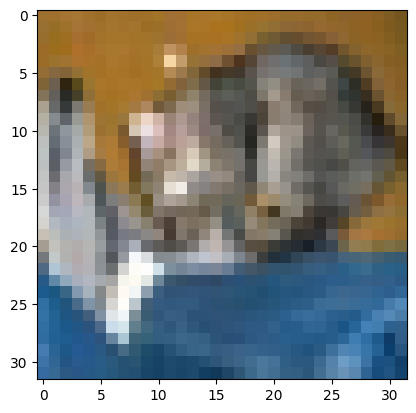

In [ ]:
import matplotlib.pyplot as plt
import torchvision
import torchvision.transforms as transforms
import torch

# Функція для відображення зображення
def imshow(img):
    img = img / 2 + 0.5     # денормалізація
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Передобробка та завантаження даних CIFAR10
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

test_set = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=128, shuffle=False)

# Отримання декількох зображень
dataiter = iter(test_loader)
images, _ = next(dataiter)

# Показ першого зображення
imshow(images[0])
